In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Conv -> Batchnorm -> Activate function Layer
'''
코드 단순화를 위한 convolution block 생성을 위한 함수
Encoder에서 사용될 예정
'''
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='relu'):
    layers = []
    
    # Conv layer
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batch Normalization
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
    
    return nn.Sequential(*layers)

# Deconv -> BatchNorm -> Activate function Layer
'''
코드 단순화를 위한 convolution block 생성을 위한 함수
Decoder에서 이미지 복원을 위해 사용될 예정
'''
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
                
    return nn.Sequential(*layers)

class Generator(nn.Module):
    # initializers
    def __init__(self):
        super(Generator, self).__init__()
        # Unet encoder
        self.conv1 = conv(3, 64, 4, bn=False, activation='lrelu') # (B, 64, 128, 128)
        self.conv2 = conv(64, 128, 4, activation='lrelu') # (B, 128, 64, 64)
        self.conv3 = conv(128, 256, 4, activation='lrelu') # (B, 256, 32, 32)
        self.conv4 = conv(256, 512, 4, activation='lrelu') # (B, 512, 16, 16)
        self.conv5 = conv(512, 512, 4, activation='lrelu') # (B, 512, 8, 8)
        self.conv6 = conv(512, 512, 4, activation='lrelu') # (B, 512, 4, 4)
        self.conv7 = conv(512, 512, 4, activation='lrelu') # (B, 512, 2, 2)
        self.conv8 = conv(512, 512, 4, bn=False, activation='relu') # (B, 512, 1, 1)

        # Unet decoder
        self.deconv1 = deconv(512, 512, 4, activation='relu') # (B, 512, 2, 2)
        self.deconv2 = deconv(1024, 512, 4, activation='relu') # (B, 512, 4, 4)
        self.deconv3 = deconv(1024, 512, 4, activation='relu') # (B, 512, 8, 8) # Hint : U-Net에서는 Encoder에서 넘어온 Feature를 Concat합니다! (Channel이 2배)
        self.deconv4 = deconv(1024, 512, 4, activation='relu') # (B, 512, 16, 16)
        self.deconv5 = deconv(1024, 256, 4, activation='relu') # (B, 256, 32, 32)
        self.deconv6 = deconv(512, 128, 4, activation='relu') # (B, 128, 64, 64)
        self.deconv7 = deconv(256, 64, 4, activation='relu') # (B, 64, 128, 128)
        self.deconv8 = deconv(128, 3, 4, activation='tanh') # (B, 3, 256, 256)

    # forward method
    def forward(self, input):
        # Unet encoder
        e1 = self.conv1(input)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.conv5(e4)
        e6 = self.conv6(e5)
        e7 = self.conv7(e6)
        e8 = self.conv8(e7)
                              
        # Unet decoder
        d1 = F.dropout(self.deconv1(e8), 0.5, training=True)
        d2 = F.dropout(self.deconv2(torch.cat([d1, e7], 1)), 0.5, training=True)
        d3 = F.dropout(self.deconv3(torch.cat([d2, e6], 1)), 0.5, training=True)
        d4 = self.deconv4(torch.cat([d3, e5], 1))
        d5 = self.deconv5(torch.cat([d4, e4], 1))
        d6 = self.deconv6(torch.cat([d5, e3], 1))
        d7 = self.deconv7(torch.cat([d6, e2], 1))
        output = self.deconv8(torch.cat([d7, e1], 1))
        
        return output

In [99]:
import torch 

generator = Generator()
# generator.load_state_dict(torch.load('min_generator.pkl'))
generator.load_state_dict(torch.load('./model/font_generator.pkl'))

<All keys matched successfully>

(216, 216, 3)
torch.Size([3, 256, 256])


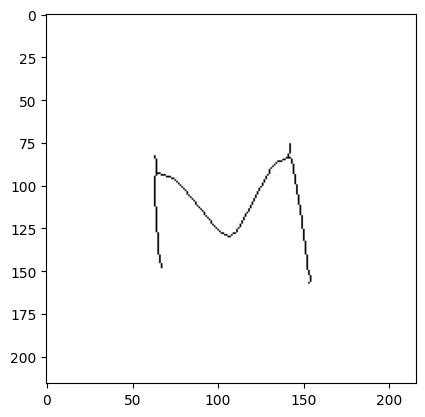

In [102]:
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

image = Image.open('./data/fonts/test/b/glyph_77.png')
real_image = Image.open('./data/fonts/test/a/glyph_77.png')
image = image.convert('RGB')
np_image = np.array(image)
print(np_image.shape)

transformed = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])
input = transformed(image)
print(input.shape)
batch = torch.unsqueeze(input, 0)

output = generator(batch)


plt.imshow(image)

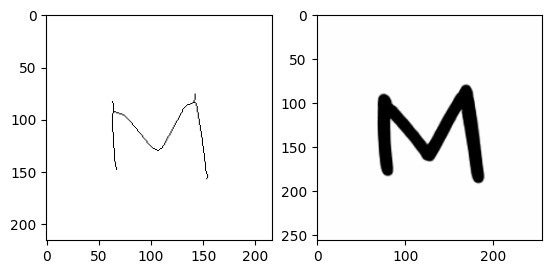

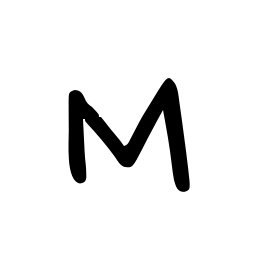

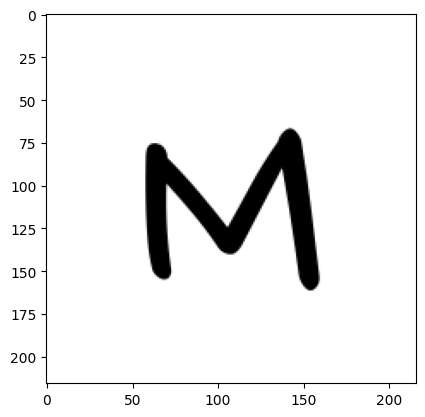

In [109]:
import matplotlib.pyplot as plt
import vtracer

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

input_array = np_image / 255
output_array = denorm(output[0]).detach().numpy().transpose(1, 2, 0)

input_image = Image.fromarray((input_array * 255).astype(np.uint8))
output_image = Image.fromarray((output_array * 255).astype(np.uint8))

plt.subplot(1, 2, 1)
plt.imshow(input_image.convert('RGB'))
plt.subplot(1, 2, 2)
plt.imshow(output_image.convert('RGB'))
plt.show()


output_image.save('output.png')

plt.imshow(real_image)



vtracer.convert_image_to_svg_py('output.png',
                                'output.svg',
                                colormode = 'binary',        # ["color"] or "binary"
                                hierarchical = 'stacked',   # ["stacked"] or "cutout"
                                mode = 'spline',            # ["spline"] "polygon", or "none"
                                filter_speckle = 50,         # default: 4
                                color_precision = 10,        # default: 6
                                layer_difference = 16,      # default: 16
                                corner_threshold = 60,      # default: 60
                                length_threshold = 4,     # in [3.5, 10] default: 4.0
                                max_iterations = 10,        # default: 10
                                splice_threshold = 80,      # default: 45
                                path_precision = 2          # default: 8
                                )

# open svg in matplotlib
import matplotlib.pyplot as plt

from IPython.display import SVG, display
display(SVG('output.svg'))
